# Analysis of Predictions Produced on Model Level with RNNModel Class by Darts

This script analyzes all pickle files in `./data/{approach}/{n_chunks}_chunks/{style}/`, starting with `confusion_matrix_models`, i.e. all model results. At the moment, the paths are adapted for local execution.

## Merge and Adjust Model Results

### Define Variables to Adjust

In [1]:
# Define approach
approach = 'RNNModel'

# Define number of chunks (1000, 2000 or 15000)
n_chunks = 2000

# Define how many chunks were taken for prediction ('all' or '20_percent')
style = 'all'

### Extract All Generated Model Results

In [2]:
import os
import pandas as pd
import pickle5 as pickle

# Define path to all model matrices produced by prediction
path_to_model_matrices = f'../../data/{approach}/{n_chunks}_chunks/{style}'

# Concat all found matrices into result matrix
result_matrix_models = pd.DataFrame(columns=['ID', 'PARAMETER', 'RUNTIME', 'MODEL', 'SCALED', 'LIBRARY', 'ENDOGENOUS',
                                             'EXOGENOUS', 'FIRST_FORECAST', 'ALARM_TYPE', 'FP', 'TP', 'FN', 'TN',
                                             'N_HIGH_ALARMS', 'N_LOW_ALARMS', 'N_CHUNKS', 'N_ITERATIONS'])

for file in os.listdir(path_to_model_matrices):
    if os.path.isfile(os.path.join(path_to_model_matrices, file)) and \
            file.startswith('confusion_matrix_models') and file.endswith('.pickle'):

        # Read file
        current_matrix_f = open(f'{path_to_model_matrices}/{file}', 'rb')
        current_matrix = pickle.load(current_matrix_f)
        current_matrix_f.close()

        # Append current matrix to result matrix
        result_matrix_models = pd.concat([result_matrix_models, current_matrix])

# Align IDs of both styles
# Note: This is only needed for old 1000-20% runs were model numbers have ranged from '01' to '18'
if style == '20_percent' and n_chunks == 1000:

    # Remove additionally calculated rows
    result_matrix_models = result_matrix_models[~((result_matrix_models['ENDOGENOUS'] == 'MAX')
                                                  & (result_matrix_models['ALARM_TYPE'] == 'Low') |
                                                  (result_matrix_models['ENDOGENOUS'] == 'MIN')
                                                  & (result_matrix_models['ALARM_TYPE'] == 'High'))]

    # Update rows IDs of scaled results
    # RNN (min)
    result_matrix_models['ID'] = result_matrix_models['ID'].str.replace('03', '02')
    # LSTM (median, max, min)
    result_matrix_models['ID'] = result_matrix_models['ID'].str.replace('04', '03')
    result_matrix_models['ID'] = result_matrix_models['ID'].str.replace('05', '04')
    result_matrix_models['ID'] = result_matrix_models['ID'].str.replace('06', '04')
    # GRU (median, max, min)
    result_matrix_models['ID'] = result_matrix_models['ID'].str.replace('07', '05')
    result_matrix_models['ID'] = result_matrix_models['ID'].str.replace('08', '06')
    result_matrix_models['ID'] = result_matrix_models['ID'].str.replace('09', '06')

    # Update rows IDs of non-scaled results
    # RNN (median, max, min)
    result_matrix_models['ID'] = result_matrix_models['ID'].str.replace('10', '07')
    result_matrix_models['ID'] = result_matrix_models['ID'].str.replace('11', '08')
    result_matrix_models['ID'] = result_matrix_models['ID'].str.replace('12', '08')
    # LSTM (median, max, min)
    result_matrix_models['ID'] = result_matrix_models['ID'].str.replace('13', '09')
    result_matrix_models['ID'] = result_matrix_models['ID'].str.replace('14', '10')
    result_matrix_models['ID'] = result_matrix_models['ID'].str.replace('15', '10')
    # GRU (median, max, min)
    result_matrix_models['ID'] = result_matrix_models['ID'].str.replace('16', '11')
    result_matrix_models['ID'] = result_matrix_models['ID'].str.replace('17', '12')
    result_matrix_models['ID'] = result_matrix_models['ID'].str.replace('18', '12')

### Add Metrics

See https://en.wikipedia.org/wiki/Sensitivity_and_specificity for more information.

In [3]:
import numpy as np

# Add confusion matrix ratios
result_matrix_models['FPR'] = result_matrix_models['FP'] / (result_matrix_models['FP'] + result_matrix_models['TN'])
result_matrix_models['TPR'] = result_matrix_models['TP'] / (result_matrix_models['TP'] + result_matrix_models['FN'])
result_matrix_models['FNR'] = result_matrix_models['FN'] / (result_matrix_models['TP'] + result_matrix_models['FN'])
result_matrix_models['TNR'] = result_matrix_models['TN'] / (result_matrix_models['FP'] + result_matrix_models['TN'])

# Add accuracy
result_matrix_models['ACC'] = (result_matrix_models['TP'] + result_matrix_models['TN']) / \
                              (result_matrix_models['TP'] + result_matrix_models['FN']
                               + result_matrix_models['FP'] + result_matrix_models['TN'])

# Add F1 score (harmonic mean of precision/PPV and sensitivity/TPR)
result_matrix_models['F1S'] = result_matrix_models['TP'] / \
                              (result_matrix_models['TP'] +
                               0.5 * (result_matrix_models['FP'] + result_matrix_models['FN']))

# Add threat score
result_matrix_models['TS'] = result_matrix_models['TP'] / (result_matrix_models['TP'] + result_matrix_models['FN'] + result_matrix_models['FP'])

# Add Matthews correlation coefficient
result_matrix_models['MCC_divident'] = result_matrix_models['TP'] * result_matrix_models['TN'] - \
                                       result_matrix_models['FP'] * result_matrix_models['FN']
result_matrix_models['MCC_divisor'] = ((result_matrix_models['TP'] + result_matrix_models['FP']) *
                                              (result_matrix_models['TP'] + result_matrix_models['FN']) *
                                              (result_matrix_models['TN'] + result_matrix_models['FP']) *
                                              (result_matrix_models['TN'] + result_matrix_models['FN']))**(1/2)
result_matrix_models['MCC'] = result_matrix_models['MCC_divident'] / result_matrix_models['MCC_divisor']

# Add weighted score from https://physionet.org/content/challenge-2015/1.0.0/
# Original: (TP + TN) / (TP + TN + FP + 5*FN)
# Adapted: (TP) / (TP + FN + 5*FP)
result_matrix_models['WEIGHTED_SCORE_AA'] = result_matrix_models['TP'] / (result_matrix_models['TP'] + result_matrix_models['FN'] + (5 * result_matrix_models['FP']))

# Round all floats to 4 decimal places
# Note: round() does not work for floats with many decimal places
decimals = 4
for col in ['FPR', 'TPR', 'FNR', 'TNR', 'ACC', 'F1S', 'TS', 'MCC', 'WEIGHTED_SCORE_AA']:
    result_matrix_models[col] = result_matrix_models[col].apply(lambda x: round(x, decimals))

# Reset index
result_matrix_models.reset_index(inplace=True, drop=True)

# Add missing runtimes
# Note: This is only needed for old 2000-all runs where script was incomplete
ids_with_missing_runtimes = result_matrix_models[result_matrix_models['RUNTIME'].isna()].ID

for i, id_high in enumerate(ids_with_missing_runtimes):
    new_runtime = result_matrix_models.loc[result_matrix_models['ID'] == (id_high[:-1] + 'L')].RUNTIME
    result_matrix_models.at[ids_with_missing_runtimes.index[i], 'RUNTIME'] = new_runtime

# Convert runtimes to integers
result_matrix_models['RUNTIME'] = result_matrix_models['RUNTIME'].round(0).astype(int)

# Move cols to end for similarity with ARIMA results and drop columns (alarm counts and MCC helper columns)
result_matrix_models = result_matrix_models[['ID', 'PARAMETER', 'RUNTIME', 'MODEL', 'SCALED', 'LIBRARY', 'ENDOGENOUS',
                                             'EXOGENOUS', 'FIRST_FORECAST', 'ALARM_TYPE', 'TP', 'FN', 'FP', 'TN',
                                             'FPR', 'TPR', 'FNR', 'TNR', 'ACC', 'F1S', 'MCC', 'TS', 'WEIGHTED_SCORE_AA',
                                             'N_CHUNKS', 'N_ITERATIONS']]

### Add Temporary Missing Rows

In [4]:
import numpy as np

# Get missing IDs
id_prefixes = [param + '_R_' + str(nr + 1) if nr >= 9 else param + '_R_0' + str(nr + 1)
               for nr in list(range(12)) for param in ['BP', 'HR', 'O2']]

all_ids = [id_prefix + '_H' for id_prefix in id_prefixes] + [id_prefix + '_L' for id_prefix in id_prefixes]

missing_ids = list(set(all_ids).difference(set(pd.unique(result_matrix_models.ID))))
print(f'Missing IDs: {missing_ids}')

if len(missing_ids) > 0:

    # Add missing rows with columns that are not row-specific
    missing_rows = pd.DataFrame(data={'ID': list(missing_ids),
                                      'LIBRARY' : ['darts'] * len(missing_ids),
                                      'FIRST_FORECAST' : [12] * len(missing_ids)})

    # Add row-specific columns
    missing_rows['PARAMETER'] = missing_rows['ID'].str[:2]
    missing_rows['ALARM_TYPE'] = ['Low' if model_id[-1] == 'L' else 'High' for model_id in missing_rows['ID'] ]

    scaled_model_numbers = ['0' + str(nr) for nr in list(range(7))][1:]
    missing_rows['SCALED'] = [True if model_id.split('_')[2] in scaled_model_numbers else False for model_id in missing_rows['ID']]

    missing_rows['MODEL'] = ['RNN' if model_id.split('_')[2] in ['01', '02', '07', '08']
                             else 'LSTM' if model_id.split('_')[2] in ['03', '04', '09', '10']
                             else 'GRU' for model_id in missing_rows['ID']]

    missing_rows['ENDOGENOUS'] = ['Median' if model_id.split('_')[2] in ['01', '07', '03', '09', '05', '11']
                                  else 'Max' if model_id[-1] == 'H'
                                  else 'Min' for model_id in missing_rows['ID']]

    missing_rows['EXOGENOUS'] = [np.nan if model_id.split('_')[2] in ['01', '07', '03', '09', '05', '11']
                                 else 'Median' for model_id in missing_rows['ID']]

    # Add missing rows
    result_matrix_models = pd.concat([result_matrix_models, missing_rows], axis=0, ignore_index=True)

Missing IDs: []


### Finalize and Save as Parquet File

In [5]:
from IPython.display import display

# Adjust data types
result_matrix_models['SCALED'] = result_matrix_models['SCALED'].astype(bool)
result_matrix_models['FIRST_FORECAST'] = result_matrix_models['FIRST_FORECAST'].astype(int)

if len(missing_ids) == 0:
    result_matrix_models['RUNTIME'] = result_matrix_models['RUNTIME'].astype(int)
    result_matrix_models['TP'] = result_matrix_models['TP'].astype(int)
    result_matrix_models['TN'] = result_matrix_models['TN'].astype(int)
    result_matrix_models['FP'] = result_matrix_models['FP'].astype(int)
    result_matrix_models['FN'] = result_matrix_models['FN'].astype(int)

# Sort result matrix for better readability
result_matrix_models.sort_values(by=['ID'], inplace=True)

# Reset index
result_matrix_models.reset_index(inplace=True, drop=True)

# Show result matrix per parameter
display(result_matrix_models[result_matrix_models['PARAMETER'] == 'BP'])
display(result_matrix_models[result_matrix_models['PARAMETER'] == 'HR'])
display(result_matrix_models[result_matrix_models['PARAMETER'] == 'O2'])

# Save as parquet file
result_matrix_models.to_parquet(f'../../data/{approach}/{n_chunks}_chunks/{style}/rnn_model_results_{n_chunks}_{style}'
                                f'.parquet', engine='pyarrow')

,ID,PARAMETER,RUNTIME,MODEL,SCALED,LIBRARY,ENDOGENOUS,EXOGENOUS,FIRST_FORECAST,ALARM_TYPE,...,TPR,FNR,TNR,ACC,F1S,MCC,TS,WEIGHTED_SCORE_AA,N_CHUNKS,N_ITERATIONS
0,BP_R_01_H,BP,5052,RNN,True,darts,Median,NaN,12,High,...,0.5887,0.4113,0.9690,0.9469,0.5637,0.5360,0.3924,0.1682,405,4838
1,BP_R_01_L,BP,5052,RNN,True,darts,Median,NaN,12,Low,...,0.1014,0.8986,0.9859,0.9589,0.1310,0.1171,0.0701,0.0314,405,4838
2,BP_R_02_H,BP,7487,RNN,True,darts,Max,Median,12,High,...,0.5392,0.4608,0.9732,0.9469,0.5515,0.5234,0.3807,0.1750,405,4838
3,BP_R_02_L,BP,7487,RNN,True,darts,Min,Median,12,Low,...,0.1538,0.8462,0.9801,0.9512,0.1806,0.1587,0.0992,0.0410,405,4838
4,BP_R_03_H,BP,9331,LSTM,True,darts,Median,NaN,12,High,...,0.5390,0.4610,0.9596,0.9351,0.4919,0.4595,0.3262,0.1265,405,4838
5,BP_R_03_L,BP,9331,LSTM,True,darts,Median,NaN,12,Low,...,0.1892,0.8108,0.9614,0.9378,0.1569,0.1276,0.0851,0.0266,405,4838
6,BP_R_04_H,BP,12659,LSTM,True,darts,Max,Median,12,High,...,0.5529,0.4471,0.9608,0.9361,0.5118,0.4794,0.3439,0.1369,405,4838
7,BP_R_04_L,BP,12659,LSTM,True,darts,Min,Median,12,Low,...,0.2012,0.7988,0.9576,0.9312,0.1696,0.1364,0.0926,0.0293,405,4838
8,BP_R_05_H,BP,15441,GRU,True,darts,Median,NaN,12,High,...,0.5638,0.4362,0.9644,0.9411,0.5274,0.4973,0.3581,0.1456,405,4838
9,BP_R_05_L,BP,15441,GRU,True,darts,Median,NaN,12,Low,...,0.1486,0.8514,0.9680,0.9429,0.1375,0.1085,0.0738,0.0245,405,4838


,ID,PARAMETER,RUNTIME,MODEL,SCALED,LIBRARY,ENDOGENOUS,EXOGENOUS,FIRST_FORECAST,ALARM_TYPE,...,TPR,FNR,TNR,ACC,F1S,MCC,TS,WEIGHTED_SCORE_AA,N_CHUNKS,N_ITERATIONS
24,HR_R_01_H,HR,70418,RNN,True,darts,Median,NaN,12,High,...,0.1257,0.8743,0.9992,0.9868,0.2123,0.2893,0.1188,0.0973,1326,48348
25,HR_R_01_L,HR,70418,RNN,True,darts,Median,NaN,12,Low,...,0.4499,0.5501,0.9981,0.9937,0.5360,0.5431,0.3661,0.2098,1326,48348
26,HR_R_02_H,HR,140152,RNN,True,darts,Max,Median,12,High,...,0.2031,0.7969,0.9970,0.9843,0.2934,0.3212,0.1719,0.1065,1326,48348
27,HR_R_02_L,HR,140152,RNN,True,darts,Min,Median,12,Low,...,0.4531,0.5469,0.9978,0.9930,0.5331,0.5383,0.3635,0.2029,1326,48348
28,HR_R_03_H,HR,86452,LSTM,True,darts,Median,NaN,12,High,...,0.2018,0.7982,0.9973,0.9861,0.2908,0.3185,0.1702,0.1046,1326,48348
29,HR_R_03_L,HR,86452,LSTM,True,darts,Median,NaN,12,Low,...,0.4576,0.5424,0.9962,0.9919,0.4753,0.4716,0.3117,0.1370,1326,48348
30,HR_R_04_H,HR,215886,LSTM,True,darts,Max,Median,12,High,...,0.2211,0.7789,0.9967,0.9843,0.3113,0.3344,0.1844,0.1108,1326,48348
31,HR_R_04_L,HR,215886,LSTM,True,darts,Min,Median,12,Low,...,0.4906,0.5094,0.9961,0.9916,0.5079,0.5040,0.3404,0.1530,1326,48348
32,HR_R_05_H,HR,130169,GRU,True,darts,Median,NaN,12,High,...,0.1974,0.8026,0.9970,0.9857,0.2812,0.3047,0.1636,0.0972,1326,48348
33,HR_R_05_L,HR,130169,GRU,True,darts,Median,NaN,12,Low,...,0.4961,0.5039,0.9973,0.9932,0.5414,0.5403,0.3712,0.1849,1326,48348


,ID,PARAMETER,RUNTIME,MODEL,SCALED,LIBRARY,ENDOGENOUS,EXOGENOUS,FIRST_FORECAST,ALARM_TYPE,...,TPR,FNR,TNR,ACC,F1S,MCC,TS,WEIGHTED_SCORE_AA,N_CHUNKS,N_ITERATIONS
48,O2_R_01_H,O2,16030,RNN,True,darts,Median,NaN,12,High,...,1.0000,0.0000,0.9979,0.9979,0.5669,0.6283,0.3956,0.1158,923,25903
49,O2_R_01_L,O2,16030,RNN,True,darts,Median,NaN,12,Low,...,0.2620,0.7380,0.9908,0.9772,0.2993,0.2910,0.1760,0.0761,923,25903
50,O2_R_02_H,O2,42136,RNN,True,darts,Max,Median,12,High,...,1.0000,0.0000,0.9957,0.9957,0.3934,0.4938,0.2449,0.0609,923,25903
51,O2_R_02_L,O2,42136,RNN,True,darts,Min,Median,12,Low,...,0.1900,0.8100,0.9860,0.9688,0.2080,0.1932,0.1161,0.0454,923,25903
52,O2_R_03_H,O2,35830,LSTM,True,darts,Median,NaN,12,High,...,1.0000,0.0000,0.9902,0.9902,0.2209,0.3506,0.1241,0.0276,923,25903
53,O2_R_03_L,O2,35830,LSTM,True,darts,Median,NaN,12,Low,...,0.1892,0.8108,0.9837,0.9689,0.1844,0.1686,0.1016,0.0356,923,25903
54,O2_R_04_H,O2,69104,LSTM,True,darts,Max,Median,12,High,...,0.9722,0.0278,0.9859,0.9859,0.1609,0.2898,0.0875,0.0189,923,25903
55,O2_R_04_L,O2,69104,LSTM,True,darts,Min,Median,12,Low,...,0.2581,0.7419,0.9774,0.9619,0.2259,0.2084,0.1273,0.0421,923,25903
56,O2_R_05_H,O2,43918,GRU,True,darts,Median,NaN,12,High,...,1.0000,0.0000,0.9827,0.9827,0.1385,0.2704,0.0744,0.0158,923,25903
57,O2_R_05_L,O2,43918,GRU,True,darts,Median,NaN,12,Low,...,0.2661,0.7339,0.9866,0.9732,0.2698,0.2562,0.1559,0.0587,923,25903


## Visualization of Model Level Results

### Defining Variables for All Model Level Plots

In [6]:
# Avoid error because of non-found values
available_parameters = pd.unique(result_matrix_models.PARAMETER)

# Only plot columns for available parameters
n_cols = len(available_parameters)

### Plot Accuracy, TPR, FNR, and TNR

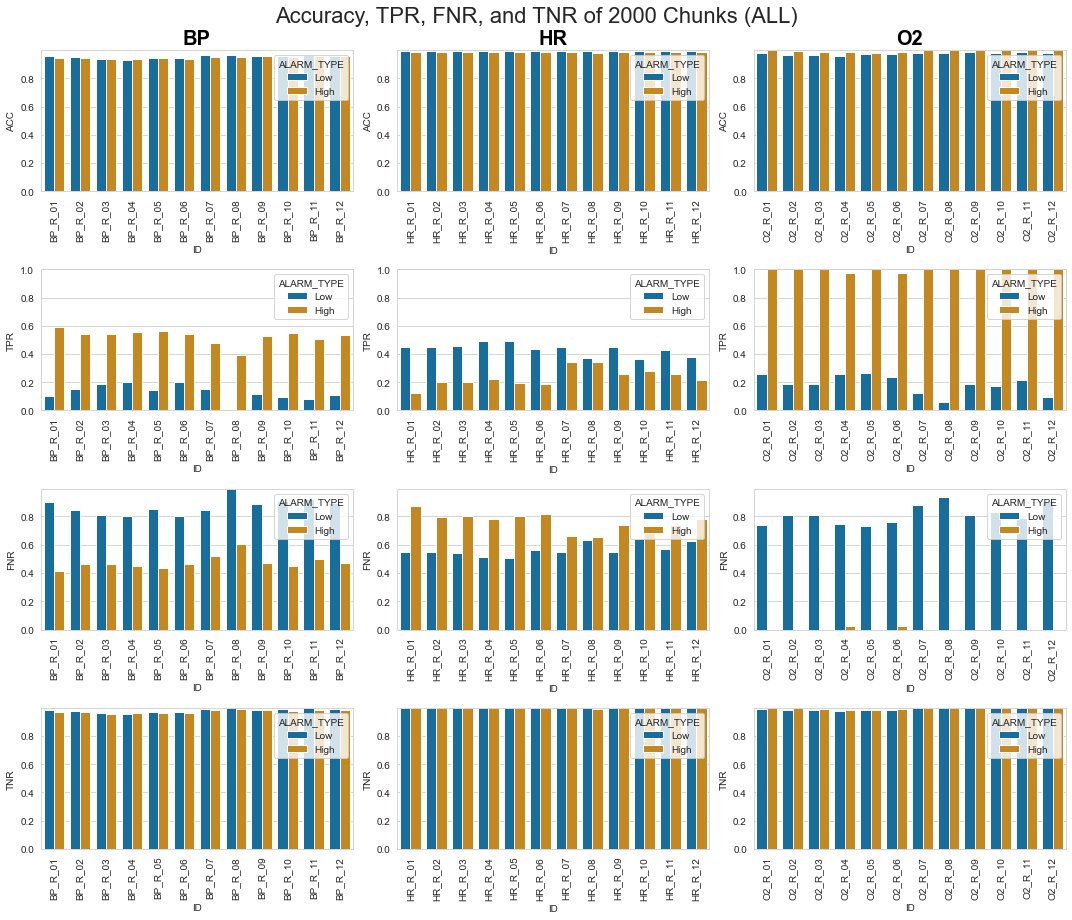

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# "Group" result matrix by prefix of ID
plotdata = result_matrix_models.replace(['_H', '_L'], ['', ''], regex=True)

# Create subplots
sns.set_style('whitegrid')
fig, axs = plt.subplots(
    nrows=4,
    ncols=n_cols,
    figsize=(15, 13),
    dpi=72
    )

plt.suptitle(f'Accuracy, TPR, FNR, and TNR of {n_chunks} Chunks ({style.replace("_", " ").upper()})', fontsize=22)

# Define y-limits
acc_ylimits = [0, max(result_matrix_models.ACC)]
tpr_ylimits = [0, max(result_matrix_models.TPR)]
fnr_ylimits = [0, max(result_matrix_models.FNR)]
tnr_ylimits = [0, max(result_matrix_models.TNR)]

# Actual plots
for i, parameter in enumerate(available_parameters):

    sns.barplot(
        ax=axs[0, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='ACC',
        hue='ALARM_TYPE',
        palette=sns.color_palette('colorblind'),
        ci=None,
        hue_order=['Low', 'High'])
    axs[0, i].set_title(str(parameter), fontweight='bold', color='black', fontsize=20)
    axs[0, i].set_ylim(acc_ylimits)
    axs[0, i].set_xticklabels(axs[0, i].get_xticklabels(), rotation=90)

    sns.barplot(
        ax=axs[1, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='TPR',
        hue='ALARM_TYPE',
        palette=sns.color_palette('colorblind'),
        ci=None,
        hue_order=['Low', 'High'])
    axs[1, i].set_ylim(tpr_ylimits)
    axs[1, i].set_xticklabels(axs[1, i].get_xticklabels(), rotation=90)

    sns.barplot(
        ax=axs[2, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='FNR',
        hue='ALARM_TYPE',
        palette=sns.color_palette('colorblind'),
        ci=None,
        hue_order=['Low', 'High'])
    axs[2, i].set_ylim(fnr_ylimits)
    axs[2, i].set_xticklabels(axs[2, i].get_xticklabels(), rotation=90)

    sns.barplot(
        ax = axs[3, i],
        data = plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='TNR',
        hue='ALARM_TYPE',
        palette=sns.color_palette('colorblind'),
        ci=None,
        hue_order=['Low', 'High'])
    axs[3, i].set_ylim(tnr_ylimits)
    axs[3, i].set_xticklabels(axs[3, i].get_xticklabels(), rotation=90)

# Improve layout and save figure
fig.tight_layout()
plt.show(fig)
fig.savefig(f'../../plots/{approach}/{n_chunks}_chunks/{style}/rnn_results_tpr_fnr_tnr_acc.png', dpi=72)

### Plot False Positive Ratio and F1 Score


##### BP #####
Best low FPR: [0.0424]
Best high FPR: [0.0404]
Best low F1S: [0.2081]
Best high F1S: [0.5948]

##### HR #####
Best low FPR: [0.004]
Best high FPR: [0.0062]
Best low F1S: [0.5491]
Best high F1S: [0.4353]

##### O2 #####
Best low FPR: [0.0226]
Best high FPR: [0.0173]
Best low F1S: [0.3323]
Best high F1S: [0.973]


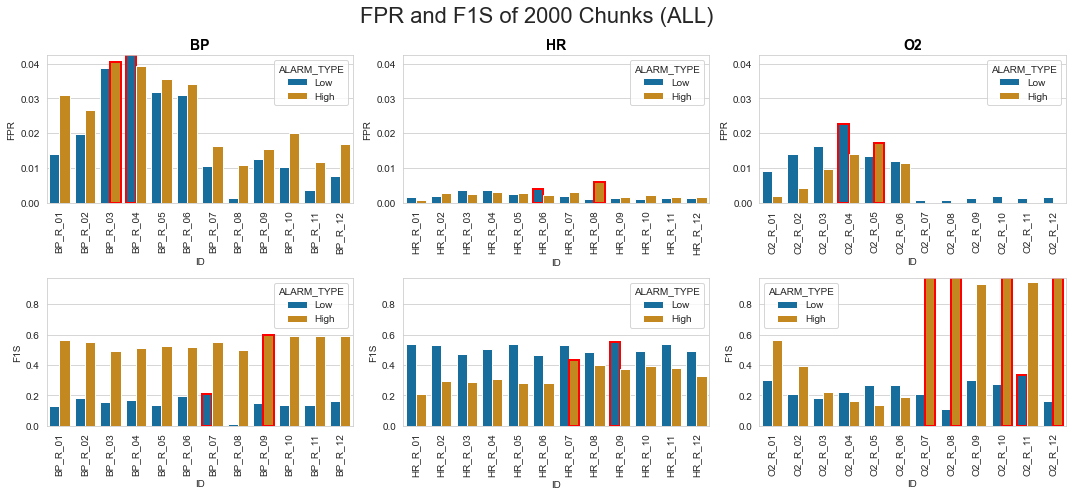

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# "Group" result matrix by prefix of ID
plotdata = result_matrix_models.replace(['_H', '_L'], ['', ''], regex=True)

# Create subplots
sns.set_style('whitegrid')
fig, axs = plt.subplots(
    nrows=2,
    ncols=n_cols,
    figsize=(15, 7),
    dpi=72
    )

plt.suptitle(f'FPR and F1S of {n_chunks} Chunks ({style.replace("_", " ").upper()})', fontsize=22)

# Define y-limits
fpr_ylimits = [0, max(result_matrix_models.FPR)]
f1s_ylimits = [0, max(result_matrix_models.F1S)]

# Actual plot
for i, parameter in enumerate(available_parameters):

    print(f'\n##### {parameter} #####')

    g_fpr = sns.barplot(
        ax=axs[0, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='FPR',
        hue='ALARM_TYPE',
        palette=sns.color_palette('colorblind'),
        ci=None,
        hue_order=['Low', 'High'])
    axs[0, i].set_title(str(parameter), fontweight='bold', color='black', fontsize=14)
    axs[0, i].set_ylim(fpr_ylimits)
    axs[0, i].set_xticklabels(axs[0, i].get_xticklabels(), rotation=90)

    # Show models with best FPR
    best_fpr_low = plotdata[plotdata.FPR == plotdata[(plotdata.PARAMETER == parameter) & (plotdata.ALARM_TYPE == 'Low')].FPR.max()]['FPR'].unique()
    print(f'Best low FPR: {best_fpr_low}')
    best_fpr_high = plotdata[plotdata.FPR == plotdata[(plotdata.PARAMETER == parameter) & (plotdata.ALARM_TYPE == 'High')].FPR.max()]['FPR'].unique()
    print(f'Best high FPR: {best_fpr_high}')

    # Add red rectangle around models with best F1 score
    for bar in g_fpr.patches:
        if bar.get_height() == best_fpr_low or bar.get_height() == best_fpr_high:
            bar.set_edgecolor('red')
            bar.set_linewidth(2)

    g_f1s = sns.barplot(
        ax=axs[1, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='F1S',
        hue='ALARM_TYPE',
        palette=sns.color_palette('colorblind'),
        ci=None,
        hue_order=['Low', 'High'])
    axs[1, i].set_ylim(f1s_ylimits)
    axs[1, i].set_xticklabels(axs[1, i].get_xticklabels(), rotation=90)

    # Show models with best F1 scores
    best_f1s_low = plotdata[plotdata.F1S == plotdata[(plotdata.PARAMETER == parameter) & (plotdata.ALARM_TYPE == 'Low')].F1S.max()]['F1S'].unique()
    print(f'Best low F1S: {best_f1s_low}')
    best_f1s_high = plotdata[plotdata.F1S == plotdata[(plotdata.PARAMETER == parameter) & (plotdata.ALARM_TYPE == 'High')].F1S.max()]['F1S'].unique()
    print(f'Best high F1S: {best_f1s_high}')

    # Add red rectangle around models with best F1 score
    for bar in g_f1s.patches:
        if bar.get_height() == best_f1s_low or bar.get_height() == best_f1s_high:
            bar.set_edgecolor('red')
            bar.set_linewidth(2)

# Improve layout and save figure
fig.tight_layout()
plt.show(fig)
fig.savefig(f'../../plots/{approach}/{n_chunks}_chunks/{style}/rnn_results_fpr_f1s.png', dpi=72)

### Plot TS, Weighted Score & MCC


##### BP #####
Best low TS: [0.1162]
Best high TS: [0.4233]
Best low WS_AA: [0.0578]
Best high WS_AA: [0.2572]
Best low MCC: [0.2045]
Best high MCC: [0.5843]

##### HR #####
Best low TS: [0.3785]
Best high TS: [0.2782]
Best low WS_AA: [0.2339]
Best high WS_AA: [0.1636]
Best low MCC: [0.5594]
Best high MCC: [0.4468]

##### O2 #####
Best low TS: [0.1992]
Best high TS: [0.9474]
Best low WS_AA: [0.1558]
Best high WS_AA: [0.7826]
Best low MCC: [0.3931]
Best high MCC: [0.9733]


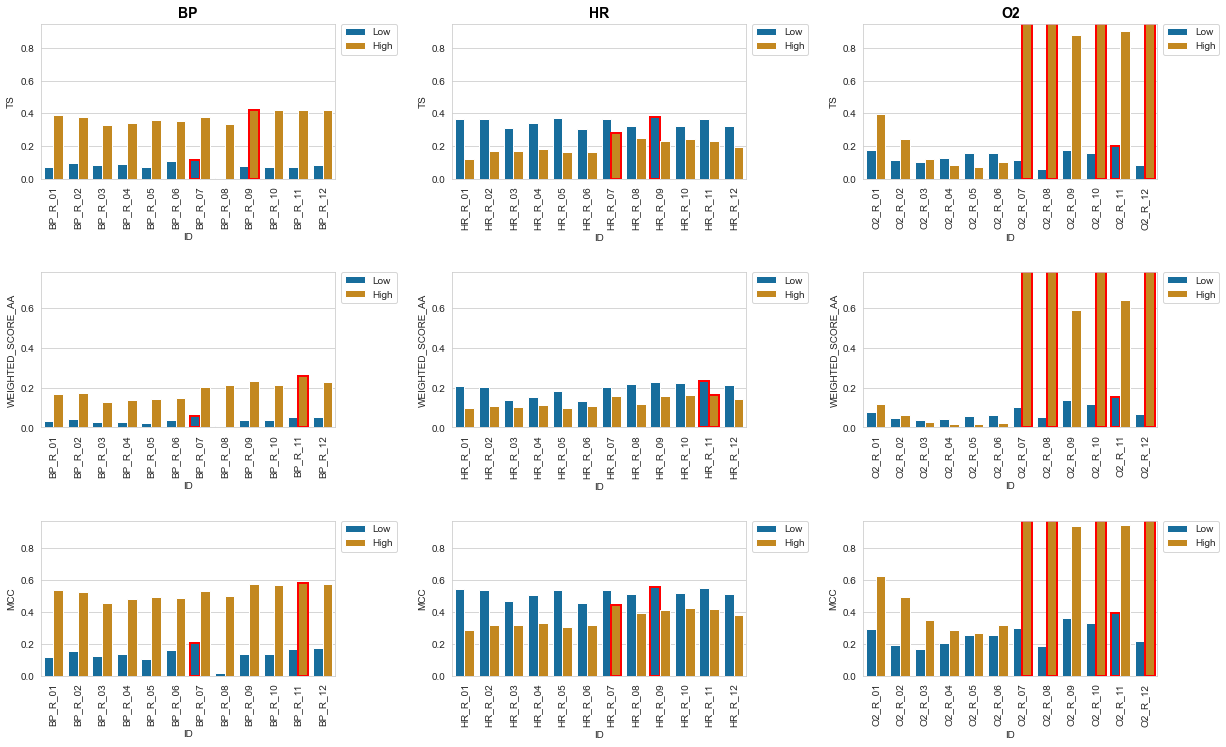

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plotdata = result_matrix_models.replace(['_H', '_L'], ['', ''], regex=True)

sns.set_style('whitegrid')

fig, axs = plt.subplots(
    nrows=3,
    ncols=n_cols,
    figsize=(20, 12),
    dpi=72
    )
fig.subplots_adjust(hspace=0.6, wspace=0.4)

ts_ylimits = [0, max(result_matrix_models.TS)]
weighted_aa_score_ylimits = [0, max(result_matrix_models.WEIGHTED_SCORE_AA)]
mcc_ylimits = [0, max(result_matrix_models.MCC)]

for i, parameter in enumerate(available_parameters):

    print(f'\n##### {parameter} #####')

    g_ts = sns.barplot(
        ax=axs[0, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='TS',
        hue='ALARM_TYPE',
        palette=sns.color_palette('colorblind'),
        ci=None,
        hue_order=['Low', 'High'])
    axs[0, i].set_title(str(parameter), fontweight='bold', color='black', fontsize=14)
    axs[0, i].set_ylim(ts_ylimits)
    axs[0, i].tick_params(axis='x', rotation=90)
    axs[0, i].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    # Show models with best TS
    best_ts_low = plotdata[plotdata.TS == plotdata[(plotdata.PARAMETER == parameter) & (plotdata.ALARM_TYPE == 'Low')].TS.max()]['TS'].unique()
    print(f'Best low TS: {best_ts_low}')
    best_ts_high = plotdata[plotdata.TS == plotdata[(plotdata.PARAMETER == parameter) & (plotdata.ALARM_TYPE == 'High')].TS.max()]['TS'].unique()
    print(f'Best high TS: {best_ts_high}')

    # Add red rectangle around models with best TS
    for bar in g_ts.patches:
        if bar.get_height() == best_ts_low or bar.get_height() == best_ts_high :
            bar.set_edgecolor('red')
            bar.set_linewidth(2)

    g_ws_aa = sns.barplot(
        ax=axs[1, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='WEIGHTED_SCORE_AA',
        hue='ALARM_TYPE',
        palette=sns.color_palette('colorblind'),
        ci=None,
        hue_order=['Low', 'High'])
    axs[1, i].set_ylim(weighted_aa_score_ylimits)
    axs[1, i].tick_params(axis='x', rotation=90)
    axs[1, i].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    # Show models with best WS_AA
    best_weighted_aa_score_low = plotdata[plotdata.WEIGHTED_SCORE_AA == plotdata[(plotdata.PARAMETER == parameter) & (plotdata.ALARM_TYPE == 'Low')].WEIGHTED_SCORE_AA.max()]['WEIGHTED_SCORE_AA'].unique()
    print(f'Best low WS_AA: {best_weighted_aa_score_low}')
    best_weighted_aa_score_high = plotdata[plotdata.WEIGHTED_SCORE_AA == plotdata[(plotdata.PARAMETER == parameter) & (plotdata.ALARM_TYPE == 'High')].WEIGHTED_SCORE_AA.max()]['WEIGHTED_SCORE_AA'].unique()
    print(f'Best high WS_AA: {best_weighted_aa_score_high}')

    # Add red rectangle around models with best WS_AA
    for bar in g_ws_aa.patches:
        if bar.get_height() == best_weighted_aa_score_low or bar.get_height() == best_weighted_aa_score_high :
            bar.set_edgecolor('red')
            bar.set_linewidth(2)

    g_mcc = sns.barplot(
        ax=axs[2, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='MCC',
        hue='ALARM_TYPE',
        palette=sns.color_palette('colorblind'),
        ci=None,
        hue_order=['Low', 'High'])
    axs[2, i].set_ylim(mcc_ylimits)
    axs[2, i].tick_params(axis='x', rotation=90)
    axs[2, i].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    # Show models with best MCC
    best_mcc_low = plotdata[plotdata.MCC == plotdata[(plotdata.PARAMETER == parameter) & (plotdata.ALARM_TYPE == 'Low')].MCC.max()]['MCC'].unique()
    print(f'Best low MCC: {best_mcc_low}')
    best_mcc_high = plotdata[plotdata.MCC == plotdata[(plotdata.PARAMETER == parameter) & (plotdata.ALARM_TYPE == 'High')].MCC.max()]['MCC'].unique()
    print(f'Best high MCC: {best_mcc_high}')

    # Add red rectangle around models with best MCC
    for bar in g_mcc.patches:
        if bar.get_height() == best_mcc_low or bar.get_height() == best_mcc_high :
            bar.set_edgecolor('red')
            bar.set_linewidth(2)

# Save figure
plt.savefig(f'../../plots/{approach}/{n_chunks}_chunks/{style}/rnn_results_ts_ws_mcc.png', dpi=72, bbox_inches='tight')
plt.show(fig)

In [10]:
# TODO: Add plots comparing model types and scaling influence

### Plot Runtimes

c:\users\ninai\onedrive\dokumente\studium\module\master\3. semester\masterprojekt\dhl2021\venv\lib\site-packages\ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\users\ninai\onedrive\dokumente\studium\module\master\3. semester\masterprojekt\dhl2021\venv\lib\site-packages\ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\users\ninai\onedrive\dokumente\studium\module\master\3. semester\masterprojekt\dhl2021\venv\lib\site-packages\ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


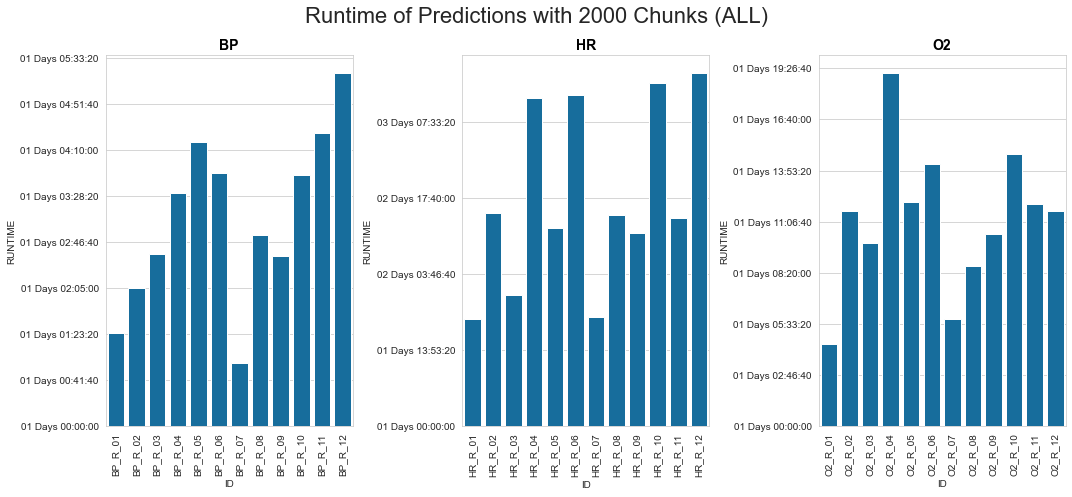

In [11]:
plotdata = result_matrix_models.replace(['_H', '_L'], ['', ''], regex=True)

# Create subplots
sns.set_style('whitegrid')
fig, axs = plt.subplots(
    nrows=1,
    ncols=n_cols,
    figsize=(15, 7),
    dpi=72
    )

# Add main title
plt.suptitle(f'Runtime of Predictions with {n_chunks} Chunks ({style.replace("_", " ").upper()})', fontsize=22)

# Add actual plot and adjust texts
for i, parameter in enumerate(available_parameters):

    sns.barplot(
        ax=axs[i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='RUNTIME',
        color=sns.color_palette('colorblind')[0],
        ci=None)
    axs[i].set_title(str(parameter), fontweight='bold', color='black', fontsize=14)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    axs[i].set_yticklabels(pd.to_datetime(axs[i].get_yticks(), unit='s')
                                 .strftime('%d Days %H:%M:%S'))

# Improve layout and save figure
fig.tight_layout()
plt.show(fig)
fig.savefig(f'../../plots/{approach}/{n_chunks}_chunks/{style}/rnn_results_runtimes.png', dpi=72)